In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys
import time

import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import words

## Part a: Extracting Language Features

In [2]:
# the interview data (sheet 1)
interview_data = pd.read_excel(
    "../data/DAIC_demographic_data.xlsx",
    sheet_name="Interview_Data",
    skiprows=lambda x: x == 1,
)
# drop the rows where data in column Partic# is NaN
interview_data = interview_data.dropna(subset=["Partic#"])
print(interview_data.tail())

# the phq score data (sheet 2)
phq_score = pd.read_excel(
    "../data/DAIC_demographic_data.xlsx", sheet_name="Metadata_mapping"
)

print(phq_score.head())

     Partic# Condition  gender  race
428    837.0        AI     2.0     3
429    838.0        AI     1.0     1
430    839.0        AI     1.0     1
431    840.0        AI     2.0     3
432    841.0        AI     1.0     4
   Participant_ID  PHQ_Score
0             300          2
1             301          3
2             302          4
3             303          0
4             304          6


The following step was a workaround to prevent the end of file error due to unclosed inverted commas. What the code is doing - opening and reading each file, reading each line and checking for lines that start with " but does not end with " (i.e., checking for unclosed quotes).

In [3]:
# preprocessing the csv files to remove the unclosed inverted commas
def clean_csv(file_path, output_path):
    with open(file_path, "r") as infile, open(output_path, "w") as outfile:
        for line in infile:
            if line.startswith('"') and not line.endswith('"\n'):
                line = line[1:]
            outfile.write(line)


def process_directory(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(".csv"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            clean_csv(input_path, output_path)


input_dir = "../data/E-DAIC_Transcripts"
output_dir = "../data/E-DAIC_Transcripts_cleaned"

process_directory(input_dir, output_dir)

In [4]:
cleaned_transcripts_path = "../data/E-DAIC_Transcripts_cleaned"

transcripts = {}

# loop through each file in the folder, load it, and store the content
for filename in os.listdir(cleaned_transcripts_path):
    if filename.endswith("_Transcript.csv"):
        participant_id = filename.split("_")[0]  # extract the participant id
        file_path = os.path.join(cleaned_transcripts_path, filename)

        df = pd.read_csv(file_path)
        transcripts[participant_id] = df

# transcripts
transcripts["386"]

,Text
0,might have pulled something that
1,I'm going to bring the great thanks so much
2,and please
3,are you okay with this yes
4,oh I'm fine I'm a little tired but I found ou...
...,...
76,yeah well after college people usually many p...
77,thank you goodbye
78,oh that was that was fast
79,but I didn't never said there wasn't any like...


In [5]:
# combine all the text data for each participant into a single string
combined_transcripts = {}

for participant_id, transcript in transcripts.items():
    combined_transcripts[participant_id] = " ".join(transcript["Text"].astype(str))

# removing extra spaces caused by newlines
for participant_id, transcript in combined_transcripts.items():
    combined_transcripts[participant_id] = " ".join(transcript.split())

# combined_transcripts

for participant_id, transcript in list(combined_transcripts.items())[:3]:
    print(participant_id, transcript)

386 might have pulled something that I'm going to bring the great thanks so much and please are you okay with this yes oh I'm fine I'm a little tired but I found out my thyroid is I think acting up so where are you from originally I was born in Canada but I've lived in California most of my life so and it's gray today too so the gray weather makes you kind of see no sluggish oh my gosh years and years ago not at all I don't think I can text to her for a long time well the air fares have gone up quite a bit in the last few years gas prices have gone up so travel as much as it's a fun thing to do it's cost-prohibitive so oh that's see everything has plus and minuses cold-weather not as much sun so I think I'd prefer getting more sun and having the warm-weather so but other than that it's it's very pretty back their natural scenery in but I like it here you know the traffic is kind of heavy but that's a small thing to deal with why did I move to LA because my family came here and started 

In [6]:
# combine the demographic data with the extracted text data

from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# create the feature extractor objects here; using the base settings for now

corpus = list(combined_transcripts.values())
tfidf_vectorizer = TfidfVectorizer(stop_words="english", token_pattern=r"\b[A-Za-z]+\b")
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

sentiment_analyzer = SentimentIntensityAnalyzer()

combined_data = []

# convert the participant id in demographic data to int for consistency
interview_data["Partic#"] = interview_data["Partic#"].astype(int)


for _, row in interview_data.iterrows():
    participant_id = str(row["Partic#"])  # convert id to match the transcript ids

    # find langauge features for this participant
    if participant_id in combined_transcripts:
        transcript = combined_transcripts[participant_id]

        # sentiment features
        sentiment_pos_scores = sentiment_analyzer.polarity_scores(transcript)["pos"]

        # sentiment features
        sentiment_neu_scores = sentiment_analyzer.polarity_scores(transcript)["neu"]

        # sentiment features
        sentiment_neg_scores = sentiment_analyzer.polarity_scores(transcript)["neg"]

        # combine all the features
        data = {
            "participant_id": participant_id,
            "condition": row["Condition"],
            "race": row["race"],
            "genderData": row["gender"],
            # "tfidf_features": tfidf_features,
            # "count_features": count_features,
            "pos_sentiment": sentiment_pos_scores,
            "neu_sentiment": sentiment_neu_scores,
            "neg_sentiment": sentiment_neg_scores,
        }

        combined_data.append(data)

# convert the combined data into a dataframe
combined_data_df = pd.DataFrame(combined_data)

# print(combined_data_df.head())

# create dataframes for tf-idf and count features
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# concatenate the original DataFrame with the TF-IDF and Count DataFrames
final_df = pd.concat([combined_data_df.reset_index(drop=True), tfidf_df], axis=1)

final_df.head()

,participant_id,condition,race,genderData,pos_sentiment,neu_sentiment,neg_sentiment,aa,aau,abandoned,...,zip,ziplining,zipping,zodiac,zoloft,zombie,zone,zuma,zurich,zz
0,386,WoZ,3,2.0,0.184,0.770,0.046,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,387,WoZ,1,1.0,0.285,0.665,0.050,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,388,WoZ,4,1.0,0.161,0.769,0.070,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,389,WoZ,1,1.0,0.116,0.827,0.057,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,390,WoZ,3,1.0,0.193,0.740,0.067,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- By removing common stop words and number, we went from $8702$ features to $8299$ features. We need to investigate how this affects the accuracy.
- Each term in the `TF-IDF` vector is considered a feature. The values represent the `TF-IDF` score for that term. A higher score could mean that the term is important to the transcript but not common in the entire list of transcripts. This is helpful in identifying the transcript's topic/sentiment.
- Initially, I decided on using the compound score, but that resulting list of scores are heavily skewed. Figuring something might be wrong, I reverted back to using individual metrics (positive, negative and neutral)

I noticed that using `CountVectorizer` just adds $8299$ more columns to the dataframe, making the already sparse dataset more sparse. Therefore, I decided to not use it.

In [7]:
# looking at the top 10 words with the highest tf-idf scores

feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum the TF-IDF scores for each feature across all documents
tfidf_scores = np.sum(tfidf_matrix.toarray(), axis=0)

# Create a DataFrame with feature names and their corresponding scores
tfidf_scores_df = pd.DataFrame({"feature": feature_names, "score": tfidf_scores})

# Sort the DataFrame by scores in descending order
tfidf_scores_df = tfidf_scores_df.sort_values(by="score", ascending=False)

# Get the top 10 features
top_10_features = tfidf_scores_df.head(10)

# Display the top 10 features
print(top_10_features)

     feature      score
6326       s  35.261808
7293       t  32.736003
4428       m  29.000342
4287    like  24.292047
4058    just  23.032052
4129    know  22.186805
2193     don  17.789652
5934  really  16.630834
3160    good  12.510597
7451   think  10.710480


In [8]:
corpus = list(combined_transcripts.values())

# create a TfidfVectorizer without removing stop words
vectorizer_no_stop_words = TfidfVectorizer(token_pattern=r"\b[A-Za-z]+\b")
vectorizer_no_stop_words.fit(corpus)
vocab_no_stop_words = set(vectorizer_no_stop_words.get_feature_names_out())

# create a TfidfVectorizer with stop_words='english'
vectorizer_with_stop_words = TfidfVectorizer(
    stop_words="english", token_pattern=r"\b[A-Za-z]+\b"
)
vectorizer_with_stop_words.fit(corpus)
vocab_with_stop_words = set(vectorizer_with_stop_words.get_feature_names_out())

# find the difference between the two vocabularies
removed_stop_words = vocab_no_stop_words - vocab_with_stop_words

print("Removed stop words number:", len(removed_stop_words))

Removed stop words number: 272


In [9]:
""" # creating 5 folds with shuffled data

from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

folds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(final_df):
    train_fold = final_df.iloc[train_index]
    test_fold = final_df.iloc[test_index]
    folds.append((train_fold, test_fold))

# display the first fold
# train_fold, test_fold = folds[0]
# print("Train Fold:")
# print(train_fold.head())
# print("\nTest Fold:")
# print(test_fold.head())

for i, (train_fold, test_fold) in enumerate(folds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n") """

' # creating 5 folds with shuffled data\n\nfrom sklearn.model_selection import KFold\n\n# initialize the KFold object with 5 splits\nkf = KFold(n_splits=5, shuffle=True, random_state=42)\n\nfolds = []\n\n# split the DataFrame into 5 folds\nfor train_index, test_index in kf.split(final_df):\n    train_fold = final_df.iloc[train_index]\n    test_fold = final_df.iloc[test_index]\n    folds.append((train_fold, test_fold))\n\n# display the first fold\n# train_fold, test_fold = folds[0]\n# print("Train Fold:")\n# print(train_fold.head())\n# print("\nTest Fold:")\n# print(test_fold.head())\n\nfor i, (train_fold, test_fold) in enumerate(folds):\n    print(f"Fold {i+1}:")\n    print(f"Train Fold Size: {len(train_fold)}")\n    print(f"Test Fold Size: {len(test_fold)}\n") '

### Optional: Doing more preprocessing to remove non-English words

_I used the NLTK library to exclude non-English words from the corpus. This reduces the number of features significantly, as you'll see below. I'm still not sure about removing the stop words though; you can try and see if disabling it helps with the performance._

_You can use this dataset to do the rest of the tasks. I only included this because I figured it might help with overfitting and consequentially, improve the model accuracies._

_For the folds, I have used the `final_df` dataset, which is the one that has $8306$ features. If you want, you can use the dataframe with the non-English words removed._

In [10]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download("words")

eng_words = set(words.words())

# preprocessing function


def preprocess_text(text):
    text = re.sub(r"\d+", "", text)  # Remove numbers
    tokens = re.findall(r"\b\w+\b", text)  # Tokenize
    valid_words = [
        token for token in tokens if token.lower() in eng_words
    ]  # Filter non-English words
    return " ".join(valid_words)


# create the feature extractor objects here; using the base settings for now

# corpus = list(combined_transcripts.values())
processed_corpus = [preprocess_text(text) for text in corpus]
tfidf_vectorizer_ = TfidfVectorizer(stop_words="english")
tfidf_matrix_ = tfidf_vectorizer_.fit_transform(processed_corpus)

sentiment_analyzer_ = SentimentIntensityAnalyzer()

combined_data_ = []

# convert the participant id in demographic data to int for consistency
interview_data["Partic#"] = interview_data["Partic#"].astype(int)


for _, row in interview_data.iterrows():
    participant_id = str(row["Partic#"])  # convert id to match the transcript ids

    # find langauge features for this participant
    if participant_id in combined_transcripts:
        transcript = combined_transcripts[participant_id]

        # sentiment features
        sentiment_pos_scores = sentiment_analyzer.polarity_scores(transcript)["pos"]

        # sentiment features
        sentiment_neu_scores = sentiment_analyzer.polarity_scores(transcript)["neu"]

        # sentiment features
        sentiment_neg_scores = sentiment_analyzer.polarity_scores(transcript)["neg"]

        # combine all the features
        data = {
            "participant_id": participant_id,
            "condition": row["Condition"],
            "race": row["race"],
            "genderData": row["gender"],
            # "tfidf_features": tfidf_features,
            # "count_features": count_features,
            "pos_sentiment": sentiment_pos_scores,
            "neu_sentiment": sentiment_neu_scores,
            "neg_sentiment": sentiment_neg_scores,
        }

        combined_data_.append(data)

# convert the combined data into a dataframe
combined_data_df_ = pd.DataFrame(combined_data_)

# print(combined_data_df.head())

# create dataframes for tf-idf and count features
tfidf_df_ = pd.DataFrame(
    tfidf_matrix_.toarray(), columns=tfidf_vectorizer_.get_feature_names_out()
)

# concatenate the original DataFrame with the TF-IDF and Count DataFrames
final_df_ = pd.concat([combined_data_df_.reset_index(drop=True), tfidf_df_], axis=1)

final_df_.head()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Noah\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


,participant_id,condition,race,genderData,pos_sentiment,neu_sentiment,neg_sentiment,aa,abandoned,ability,...,youth,yule,zany,zero,zest,zip,zipping,zodiac,zombie,zone
0,386,WoZ,3,2.0,0.184,0.770,0.046,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,387,WoZ,1,1.0,0.285,0.665,0.050,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,388,WoZ,4,1.0,0.161,0.769,0.070,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,389,WoZ,1,1.0,0.116,0.827,0.057,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,390,WoZ,3,1.0,0.193,0.740,0.067,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


By excluding non-english words, along with removing stop words, I was able to reduce the number of features significantly - from $8299$ to $5327$. This may produce better results.

In [11]:
feature_names_ = tfidf_vectorizer_.get_feature_names_out()

# Sum the TF-IDF scores for each feature across all documents
tfidf_scores_ = np.sum(tfidf_matrix_.toarray(), axis=0)

# Create a DataFrame with feature names and their corresponding scores
tfidf_scores_df_ = pd.DataFrame({"feature": feature_names_, "score": tfidf_scores_})

# Sort the DataFrame by scores in descending order
tfidf_scores_df_ = tfidf_scores_df_.sort_values(by="score", ascending=False)

# Get the top 10 features
top_10_features_ = tfidf_scores_df_.head(10)

# Display the top 10 features
print(top_10_features_)

     feature      score
2752    like  29.028222
2612    just  27.465559
2650    know  26.661350
1405     don  21.508594
3770  really  19.885133
2048    good  14.995024
4768   think  12.867584
3400  people  12.553898
4795    time  12.395769
2044   going  11.075604


## Part b: Classifying by Gender

In [80]:
useNonEnglishWordRemovalDatasetFlag = False

if useNonEnglishWordRemovalDatasetFlag:
    genderDF = final_df_.drop(["race", "condition", "participant_id"], axis=1)
else:
    genderDF = final_df.drop(["race", "condition", "participant_id"], axis=1)

genderDF = genderDF.dropna()

# map gender from [1,2] -> [0,1] (XGBoost needs the labels to be 0 or 1)
genderDF["genderData"] = genderDF["genderData"].map({1: 0, 2: 1})

targetGender = genderDF.pop("genderData")

In [81]:
from scipy.stats import pearsonr

genderCorr = []

for i, (cols) in enumerate(genderDF.columns):

    corr, p = pearsonr(genderDF[cols], targetGender)
    genderCorr.append(corr)

genderCorr = np.array(genderCorr)

In [83]:
genderCorr[np.isnan(genderCorr)] = 0

In [84]:
idx = np.argsort(genderCorr)
idx = idx[::-1]

top10Cols = genderDF.columns[idx[:10]].tolist()
top10Scores = np.sort(genderCorr)
top10Scores = top10Scores[::-1]
top10Scores = top10Scores[:10]

print("Top 10 Pearson's Coefficients: ")
print("------------------------------")
for ii in range(10):
    print(f"{top10Cols[ii]}: {top10Scores[ii]}")

Top 10 Pearson's Coefficients: 
------------------------------
interested: 0.3216223838313521
boyfriend: 0.30847090696221235
making: 0.29691852364308696
husband: 0.27878221947259696
class: 0.26253202139488074
child: 0.26227243387190746
quickly: 0.2556227327674824
love: 0.2480364999027526
think: 0.24425767597738657
really: 0.24380424882054946


In [85]:
from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

genderFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(genderDF):
    train_fold = genderDF.iloc[train_index]
    test_fold = genderDF.iloc[test_index]
    train_target_fold = targetGender.iloc[train_index]
    test_target_fold = targetGender.iloc[test_index]
    genderFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))

for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(genderFolds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n")

Fold 1:
Train Fold Size: 150
Test Fold Size: 38

Fold 2:
Train Fold Size: 150
Test Fold Size: 38

Fold 3:
Train Fold Size: 150
Test Fold Size: 38

Fold 4:
Train Fold Size: 151
Test Fold Size: 37

Fold 5:
Train Fold Size: 151
Test Fold Size: 37



In [86]:
# helper function to calcualte accuracy and balanced accuracy
def getAccAndBAcc(yPred, yTrue):

    truePos = 0
    trueNeg = 0
    falsePos = 0
    falseNeg = 0

    for idx in range(len(yPred)):
        
        if yPred[idx] == 1:

            if yTrue[idx] == 1:

                truePos += 1

            else:

                falseNeg += 1

        else:

            if yTrue[idx] == 1:

                falsePos += 1

            else:

                trueNeg += 1

    if (trueNeg+falsePos) == 0 and (truePos+falseNeg) != 0:
        balancedAccuracy = 0.5*truePos/(truePos+falseNeg)
    elif (trueNeg+falsePos) != 0 and (truePos+falseNeg) == 0:
        balancedAccuracy = 0.5*trueNeg/(trueNeg+falsePos)
    else:
        balancedAccuracy = 0.5*trueNeg/(trueNeg+falsePos) + 0.5*truePos/(truePos+falseNeg)
    
    accuracy = (truePos + trueNeg) / (truePos + trueNeg + falsePos + falseNeg)

    return accuracy, balancedAccuracy

In [87]:
# create deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def getDLModel(inputShape):

    model = Sequential([
        Dense(128, activation='relu', input_shape=(inputShape,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='relu'),
        Dense(1, activation="sigmoid")
    ]) 

    """ model = Sequential([
        Dense(32, activation='relu', input_shape=(inputShape,)),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='relu'),
        Dense(1, activation="sigmoid")
    ]) """

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics = ["accuracy"]
    )

    return model

In [89]:
import xgboost as xgb

numberOfFeatures = [len(genderDF.columns)-1, 4000, 3000, 2000, 1000, 500, 100, 50]

bAccTree = []
accTree  = []

bAccDL = []
accDL  = []

top_n_idx = lambda data, n: np.argsort(data)[-n:]

for n in numberOfFeatures:

    nIdx = top_n_idx(genderCorr, n)

    nCols = genderDF.columns[nIdx]

    foldAccTree = []
    foldBAccTree = []

    foldAccDL = []
    foldBAccDL = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(genderFolds):

        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # train XGBoost model
        xgb_classifier = xgb.XGBClassifier()
        xgb_classifier.fit(train_fold, train_target_fold)

        # get test accuracy and balanced accuracy
        acc, bAcc = getAccAndBAcc(xgb_classifier.predict(test_fold), test_target_fold.to_numpy())

        # store accuracies
        foldAccTree.append(acc)
        foldBAccTree.append(bAcc)

        # train DL model
        FNN = getDLModel(train_fold.shape[1])
        FNN.fit(train_fold, train_target_fold, epochs=10, verbose=0)

        # get test accuracy and balanced accuracy
        acc, bAcc = getAccAndBAcc(FNN.predict(test_fold), test_target_fold.to_numpy())

        # store accuracies
        foldAccDL.append(acc)
        foldBAccDL.append(bAcc)

    accTree.append(np.mean(foldAccTree))
    bAccTree.append(np.mean(foldBAccTree))
    
    accDL.append(np.mean(foldAccDL))
    bAccDL.append(np.mean(foldBAccDL))

print("\n")
for idx in range(len(numberOfFeatures)):

    print("#######################################")
    print(f"Values for {numberOfFeatures[idx]} top features:")
    print(f"Tree accuracy: {accTree[idx]}")
    print(f"Tree balanced accuracy: {bAccTree[idx]}")
    print(f"DL accuracy: {accDL[idx]}")
    print(f"DL balanced accuracy: {bAccDL[idx]}")


maxTreeBAccNumFeatures = numberOfFeatures[np.argmax(bAccTree)]
maxDLBAccNumFeatures = numberOfFeatures[np.argmax(bAccDL)]

print("\n")
print("#######################################")
print(f"Max Tree Number of Features: {maxTreeBAccNumFeatures}, with balanced accuracy of {np.max(bAccTree) * 100}%")
print(f"Max DL Number of Features: {maxDLBAccNumFeatures}, with balanced accuracy of {np.max(bAccDL) * 100}%")
print("#######################################")
    

2/2 [==============================] - 0s 1000us/step


#######################################
Values for 8299 top features:
Tree accuracy: 0.6541963015647226
Tree balanced accuracy: 0.6286279289037909
DL accuracy: 0.6113798008534851
DL balanced accuracy: 0.30568990042674254
#######################################
Values for 4000 top features:
Tree accuracy: 0.6600284495021338
Tree balanced accuracy: 0.6597334147334147
DL accuracy: 0.6113798008534851
DL balanced accuracy: 0.30568990042674254
#######################################
Values for 3000 top features:
Tree accuracy: 0.6223328591749644
Tree balanced accuracy: 0.6043737228607918
DL accuracy: 0.6113798008534851
DL balanced accuracy: 0.30568990042674254
#######################################
Values for 2000 top features:
Tree accuracy: 0.7237553342816501
Tree balanced accuracy: 0.7313808260704813
DL accuracy: 0.6113798008534851
DL balanced accuracy: 0.30568990042674254
#######################################
Values for 1000 top 

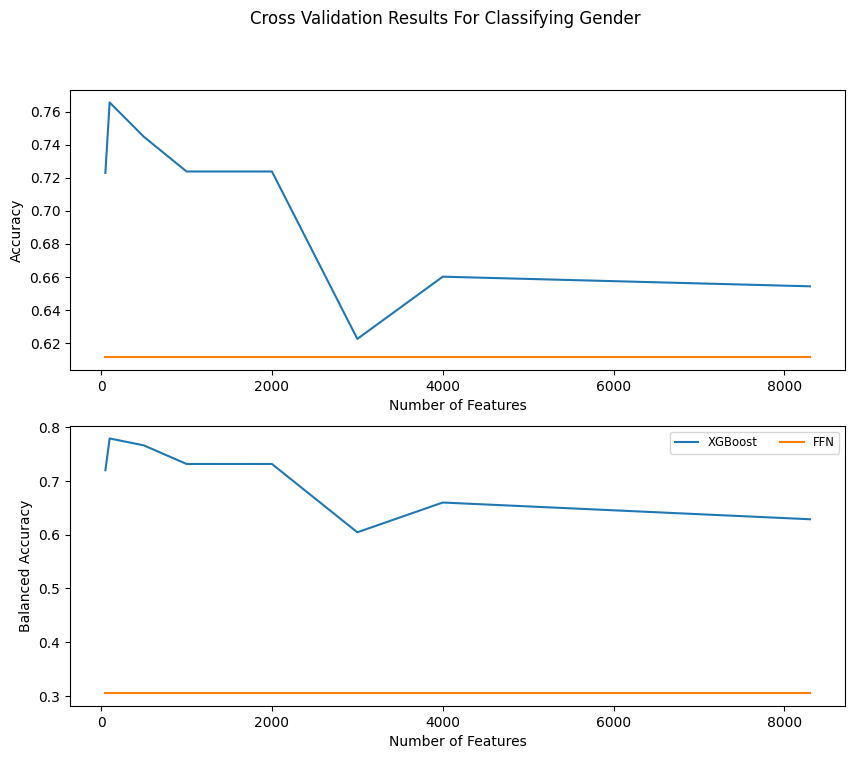

In [90]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(2, figsize=(10, 8))
fig.suptitle("Cross Validation Results For Classifying Gender")
ax[0].plot(numberOfFeatures, accTree, label="XGBoost")
ax[0].plot(numberOfFeatures, accDL, label="FFN")
ax[0].set(xlabel="Number of Features", ylabel="Accuracy")
plt.legend()

ax[1].plot(numberOfFeatures, bAccTree, label="XGBoost")
ax[1].plot(numberOfFeatures, bAccDL, label="FFN")
ax[1].set(xlabel="Number of Features", ylabel="Balanced Accuracy")

plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.show()